# Analysis of LDC1-6 Radler SGWB

## Settings and import modules

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from scipy import signal, constants

## Analyse the data without noises


Load data

In [2]:
def print_attrs(name, obj):
    shift = name.count('/') * '    '
    print(shift + name)
    for key, val in obj.attrs.items():
        print(shift + '    ' + f"{key}: {val}")

In [3]:
filepath = '/Users/qb265383/Data/mldc/LDC1-6_SGWB_v1_noiseless.hdf5'
fid = h5py.File(filepath)
fid.visititems(print_attrs)
fid.close()

H5LISA
    H5LISA/Author
    H5LISA/GWSources
        H5LISA/GWSources/SGWB-0
            H5LISA/GWSources/SGWB-0/Approximant
                Units: name
            H5LISA/GWSources/SGWB-0/EnergyAmplitude
                Units: dimensionless
            H5LISA/GWSources/SGWB-0/EnergySlope
                Units: dimensionless
            H5LISA/GWSources/SGWB-0/FrequencyRef
                Units: Hertz
            H5LISA/GWSources/SGWB-0/FrequencyShape
                Units: name
            H5LISA/GWSources/SGWB-0/Sky
                Units: name
    H5LISA/History
        H5LISA/History/0000
        H5LISA/History/0001
        H5LISA/History/0002
    H5LISA/Observatory
        H5LISA/Observatory/DataModels
            H5LISA/Observatory/DataModels/sci1
                H5LISA/Observatory/DataModels/sci1/FilterType
                    Units: None
                H5LISA/Observatory/DataModels/sci1/Inputs
                    H5LISA/Observatory/DataModels/sci1/Inputs/beam1
                

In [4]:
fid = h5py.File(filepath)

# get the source parameters
names = np.array(fid['H5LISA/GWSources/SGWB-0'])
params = [fid['H5LISA/GWSources/SGWB-0'][k][()] for k in names]
# params = [np.array(p) for p in params if p.shape]
# cat = np.rec.fromarrays(params, names=list(names))
# pd.DataFrame(cat)
fid.close()

In [5]:
# get TDI
fid = h5py.File(filepath)
tdi = np.array(fid["H5LISA/PreProcess/TDIdata"])
tdi = np.rec.fromarrays(list(tdi.T), names=["t", "X", "Y", "Z"])
tdi_df = pd.DataFrame(tdi)
fid.close()

In [6]:
tdi_df

,t,X,Y,Z
0,5.0,-3.952159e-22,-6.954395e-23,5.410955e-23
1,10.0,-1.827621e-23,-1.251368e-22,7.050767e-23
2,15.0,3.109977e-22,-2.514306e-22,-2.405176e-23
3,20.0,4.802167e-22,-1.937931e-22,-1.725940e-22
4,25.0,4.550575e-22,2.012945e-23,-2.304222e-22
...,...,...,...,...
12623036,63115185.0,-1.512315e-22,5.015254e-22,-1.495767e-22
12623037,63115190.0,-3.481624e-22,4.829681e-22,-8.979199e-23
12623038,63115195.0,-3.866922e-22,3.874086e-22,-1.229398e-23
12623039,63115200.0,-1.473032e-22,3.522601e-23,1.228748e-22


Compute PSD with number of samples in each segment adjusted to have minimal frequency at $10^{-5}$ Hz

In [7]:
 dt = tdi['t'][1]-tdi['t'][0]
 nperseg = 5 * 1.0/ dt / 1e-5

Text(0.5, 0, 'Freq [Hz]')

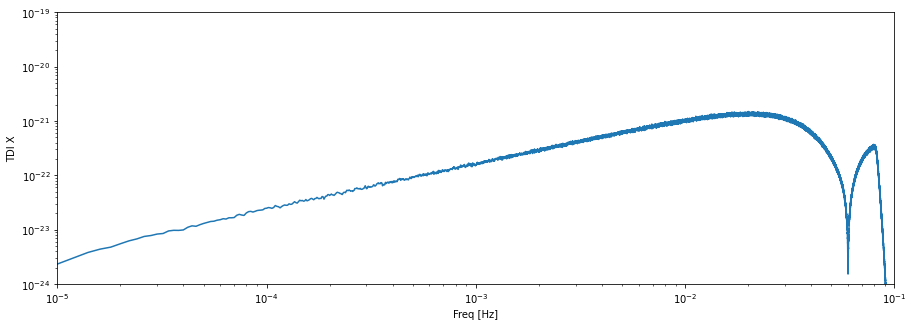

In [8]:
plt.figure(figsize=(15,5))
f, psd_x = signal.welch(tdi["X"], fs=1.0/dt, window='hanning', nperseg=nperseg)
plt.loglog(f, np.sqrt(psd_x))
plt.axis([1e-5, 1/dt/2, 1e-24, 1e-19])
plt.ylabel("TDI X")
plt.xlabel("Freq [Hz]")

## Analyse the data with noises

In [9]:
filepath_noisy = '/Users/qb265383/Data/mldc/LDC1-6_SGWB_v1.hdf5'
# get TDI
fid = h5py.File(filepath_noisy)
tdi_noisy = np.array(fid["H5LISA/PreProcess/TDIdata"])
tdi_noisy = np.rec.fromarrays(list(tdi_noisy.T), names=["t", "X", "Y", "Z"])
tdi_noisy_df = pd.DataFrame(tdi_noisy)
fid.close()

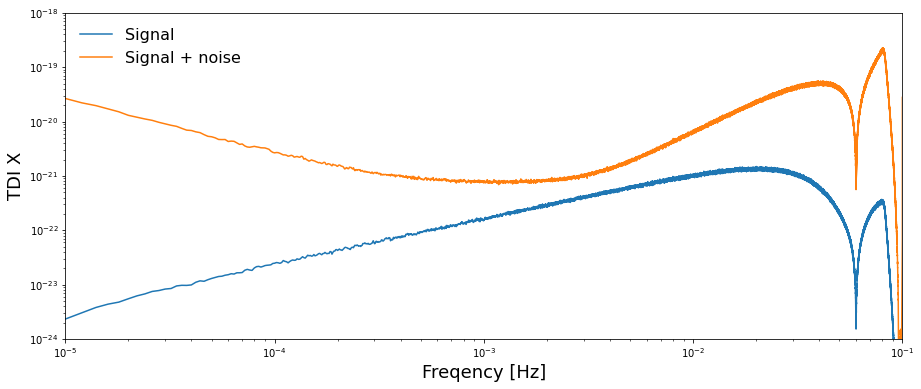

In [10]:
plt.figure(figsize=(15,6))
f, psd_x_noisy = signal.welch(tdi_noisy["X"], fs=1.0/dt, window='hanning', nperseg=nperseg)
plt.loglog(f, np.sqrt(psd_x), label='Signal')
plt.loglog(f, np.sqrt(psd_x_noisy), label='Signal + noise')
plt.axis([1e-5, 1/dt/2, 1e-24, 1e-18])
plt.ylabel("TDI X", fontsize=18)
plt.xlabel("Freqency [Hz]", fontsize=18)
plt.legend(loc='upper left', fontsize=16, frameon=False)
# plt.savefig('/Users/qb265383/Data/mldc/tdi_x_periodogram.png')

## Compare with theoretical model for signal and noise

### Noise PSD model

In [11]:
# Noise model
from ldc.lisa import noise

noise_model = "SciRDv1"
fr = f[f>0]
nmodel = noise.get_noise_model(noise_model, fr)
npsd = nmodel.psd(option='X') # could be A, E, XY

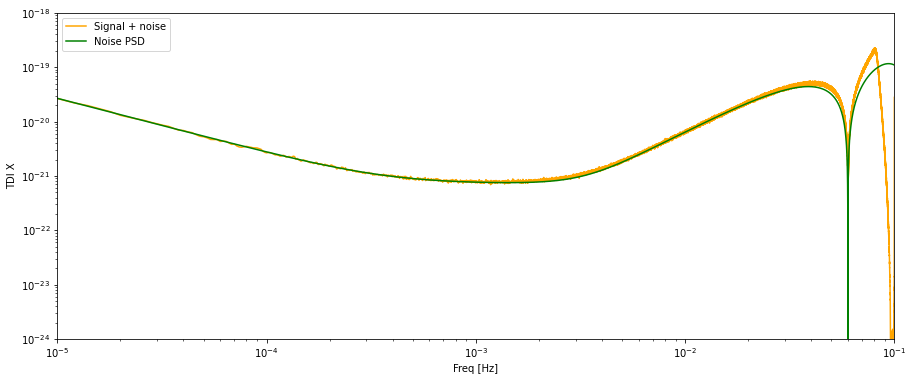

In [12]:
plt.figure(figsize=(15,6))
f, psd_x_noisy = signal.welch(tdi_noisy["X"], fs=1.0/dt, window='hanning', nperseg=nperseg)
plt.loglog(f, np.sqrt(psd_x_noisy), label='Signal + noise', color='orange')
plt.loglog(fr, np.sqrt(npsd), label='Noise PSD', color='green')
plt.axis([1e-5, 1/dt/2, 1e-24, 1e-18])
plt.ylabel("TDI X")
plt.xlabel("Freq [Hz]")
plt.legend(loc='upper left')

### SGWB PSD model

Get instrument response

In [13]:
# Load instrument response in the old MLDC repository
dir_ldc = '/Users/qb265383/Codes/MLDC/'
Ri = np.load(dir_ldc + '/datasets/Radler/LC2_Sim_RespGW_X.npy')
R = np.interp(fr, Ri['f'], Ri['X'])

Get parameters of the model

In [14]:
print(names)

['Approximant' 'EnergyAmplitude' 'EnergySlope' 'FrequencyRef'
 'FrequencyShape' 'Sky']


In [15]:
# Energy amplitude
Om0_th = params[1]
# Energy slope
slope_th = params[2]
# FrequencyRef
fstar = params[3]
# Compute frequency-dependent energy amplitude
Om_th = Om0_th * (fr/fstar)**slope_th

In [16]:
# Hubble constant
H0 = 67.1
H0_SI = H0 * 1000 / (1e6*constants.parsec)
# Compute theoretical SGWB PSD in X channel
Sh_gw = Om_th / ((4. * np.pi**2 * fr**3 ) / (3. * H0_SI*H0_SI ))
Sx_gw = Sh_gw * R

Plot to compare data and analytical model

Text(0.5, 0, 'Freq [Hz]')

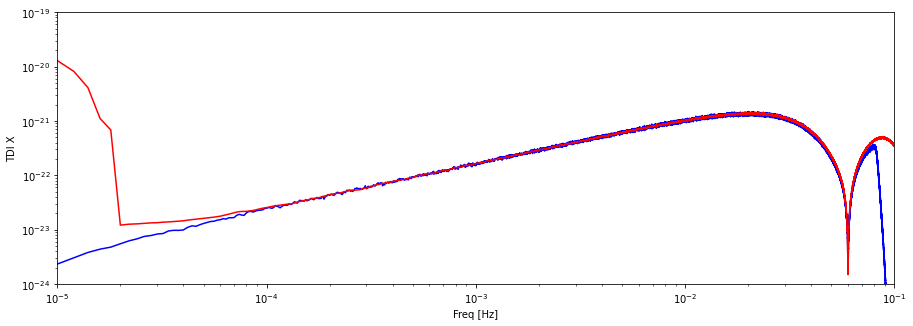

In [17]:
plt.figure(figsize=(15,5))
plt.loglog(f, np.sqrt(psd_x), color='blue', label='X signal data')
plt.loglog(fr, np.sqrt(Sx_gw), color='red', label='PSD model')
plt.axis([1e-5, 1/dt/2, 1e-24, 1e-19])
plt.ylabel("TDI X")
plt.xlabel("Freq [Hz]")